In [1]:
import pandas as pd
import numpy as np
import copy
import sklearn
from matplotlib import pyplot as plt
import hydroeval as he

In [2]:
from cgdrom import cgdrom_general
from cgdrom import conceptual_s_curve

### Running the $General Model$ 

In [5]:
# metadata involves all the needed information to run C+GDROM General Model for a reservoir, 
#          which includes the six parameters of derived conceptual storage curve, 
#          statistics of inflows, and information of reservoir capacity.
df_meta = pd.read_csv("parameters\metadata_256reservoirs.csv")
df_meta.columns

Index(['ID', 'main_use', 'size_ratio', 'curve_shape', 'A1', 'A2', 'A3', 'A4',
       'S_A4-A1', 'S_A2-A3', 'S_median', 'I99', 'I80', 'I50', 'I30', 'I10',
       'I_mean', 'S_cap', 'S_dead', 'S_flood_cap'],
      dtype='object')

In [6]:
# %%%%%%%%%%%%%%%
# We choose one reservoir for demonstration
select_id = '1020' # GRanD ID of the selected reservoir

# %%%%%%%%%%%%%%%
# providing the data of the studied period (at least including date and inflow series)
df = pd.read_csv('data\\'+select_id+'.csv') 
df['Time'] = pd.to_datetime(df["Time"])
df['month'] = df["Time"].dt.month
df['day_of_month'] = df["Time"].dt.day
df['DOY'] = df["Time"].dt.dayofyear
df = df[df['Time']>='1990-01-01']
df = df.reset_index(drop=True)

# providing intial storage and inflow series of the studied period to the model
S0 = df['storage'][0] # if unavailable, users may set half of the storage capacity as an approximation
df_I_test = df[['Time','netinflow', 'month', 'day_of_month', 'DOY']]

In [7]:
# %%%%%%%%%%%%%%%
# extracting basic features of reservoir inflow and storage capacity
select_res = df_meta.loc[df_meta['ID']==int(select_id),:]
I_stat = select_res[['I99', 'I80', 'I50', 'I30', 'I10', 'I_mean']].values[0]
S_info = select_res[['S_cap', 'S_dead', 'S_flood_cap', 'size_ratio']].values[0]
size_ratio = S_info[3]

# %%%%%%%%%%%%%%%
# deriving typical storage for each DOY based on the pre-derived storage curve parameters
curve_shape = select_res['curve_shape'].values[0]
if curve_shape == "four-piece":
    Sty_a1, Sty_a2 = select_res[['S_A4-A1', 'S_A2-A3']].values[0]
    Sty_month1, Sty_month2, Sty_month3, Sty_month4= [int(x) for x in select_res[['A1', 'A2', 'A3', 'A4']].values[0]]
    df_Sty0 = conceptual_s_curve.doy_typical_storage(Sty_month1, Sty_month2, Sty_month3, Sty_month4, Sty_a1, Sty_a2)
else:
    df_Sty0 = float(select_res['S_median'].values[0])

# %%%%%%%%%%%%%%%
# Prediction & Evaluation
# determing default parameters in the General Model
Q1, Q2, Q3, R_flood = cgdrom_general.general_default_parameters(I_stat, size_ratio)

# predicting operations using the General Model
R_sim, S_sim = cgdrom_general.predict_general_series(df_I_test, df_Sty0, S0, Q1, Q2, Q3, R_flood, I_stat, S_info)

# evaluation (when observations are available): 
NSE = he.evaluator(he.nse, R_sim, df['outflow'])
NSE_S = he.evaluator(he.nse, S_sim, df['storage'])
KGE, kge_r, kge_alpha, kge_beta = he.evaluator(he.kge, R_sim, df['outflow'])
KGE_S, kge_r_S, kge_alpha_S, kge_beta_S = he.evaluator(he.kge, S_sim, df['storage'])

print("NSEs for R and S simulations: "+str(NSE[0])+', '+str(NSE_S[0]))
print("KGEs for R and S simulations: "+str(KGE[0])+', '+str(KGE_S[0]))



NSEs for R and S simulations: 0.6863960751157445, 0.7999139103555274
KGEs for R and S simulations: 0.779522655157035, 0.8564817647123029


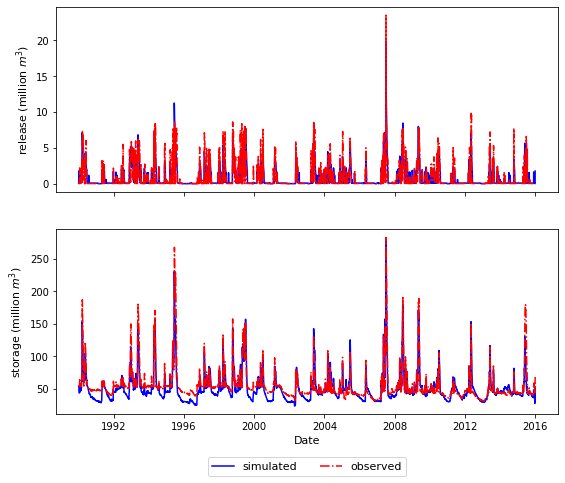

In [8]:
f, ax = plt.subplots(2, 1, figsize=(9, 7.5), sharex=True)
ax[0].plot(df['Time'], R_sim, linestyle='-',  color='b')
ax[0].plot(df['Time'], df['outflow'], linestyle='-.', color='r')
ax[0].set_ylabel('release (million $m^3$)',fontsize=11)

ax[1].plot(df['Time'] , S_sim, linestyle='-',  color='b')
ax[1].plot(df['Time'], df['storage'], linestyle='-.', color='r')
ax[1].set_ylabel('storage (million $m^3$)',fontsize=11)
ax[1].set_xlabel('Date', fontsize=11)
ax[1].legend(['simulated','observed'],fontsize=11, loc='upper center', markerscale=5, ncol=2, bbox_to_anchor=(0.5, -0.2))

plt.show()